# 코로나 확진자 예측모델 만들기

1. ARIMA 모델을 이용하여 예측하기
2. Prophet 모델을 이용하여 예측하기

## 1.ARIMA 모델을 이용하여 예측하기

In [ ]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn import (datasets, linear_model, svm)
import csv

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


+ 데이터 가져오기   
전세계 지역별 화진자, 회복자, 사망자 data set를 가지고 옵니다.


In [ ]:
url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv'
data = pd.read_csv(url, error_bad_lines=False)

data.head()

,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,0,0.0,0
1,2020-01-23,Afghanistan,NaN,0,0.0,0
2,2020-01-24,Afghanistan,NaN,0,0.0,0
3,2020-01-25,Afghanistan,NaN,0,0.0,0
4,2020-01-26,Afghanistan,NaN,0,0.0,0


+ 데이터 가공하기   
data set에서 날짜와 확진자 수를 가지고 옵니다.


In [ ]:
korea = data[data['Country/Region'] == 'Korea, South']

korea = np.column_stack([korea.Date, korea.Confirmed]) #두 배열 붙이기
korea =  pd.DataFrame(korea)

korea = korea.reset_index().rename(columns={0: 'date', 1: 'confirmed'})
korea = korea.drop("index", axis=1)

korea.tail() #데이터 마지막 5줄 출력

,date,confirmed
694,2021-12-16,551551
695,2021-12-17,558864
696,2021-12-18,565098
697,2021-12-19,570414
698,2021-12-20,575615


+  확진자 표현 (3달)

In [ ]:
korea['date'] = pd.to_datetime(korea['date']) #object -> date
korea['confirmed'] = korea['confirmed'].astype(int) #object -> int

df_date = korea['date'].iloc[608:]
df_confimed = korea['confirmed'].iloc[608:]

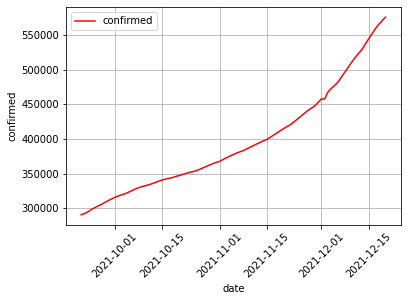

In [ ]:
#3달간 확진자 수
plt.figure()
plt.plot(df_date, df_confimed, 'r', label = "confirmed")
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ylabel('confirmed')

plt.grid()
plt.legend()

2021-11-15 기준으로 확진자 추이가 가파라진것을 확인할 수 있습니다.

+ 예측모델만들기   
  3달을 기준으로 전반적으로 우상향 그래프 형태이며 예측 모델을 실행해여 그래프로 나타내었으나 변동을 눈으로 확인하기 어려워 최근 14일을 기준으로 모델을 만들었습니다.

In [ ]:
train_df = korea[593:683]
test_df = korea[684:]

model = ARIMA(train_df.confirmed.values, order = (1,1,2)) #시간의 흐름에 따른 분석
#AR은 과거분석, AR = 2는 변동이 너무 심하여 조정하였음

model_fit = model.fit(trend = 'c', full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   89
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -736.513
Method:                       css-mle   S.D. of innovations            937.783
Date:                Tue, 21 Dec 2021   AIC                           1483.026
Time:                        13:34:15   BIC                           1495.470
Sample:                             1   HQIC                          1488.042
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3180.9154   1269.795      2.505      0.014     692.162    5669.669
ar.L1.D.y      0.9860      0.017     57.161      0.000       0.952       1.020
ma.L1.D.y     -1.0844      0.121     -8.967      0.0

p value 0.05수준이라고 판단하여 MA(1)은 유효하다고 판단하여 order(1,1,2)을 가지고 예측모델을 만들었습니다.

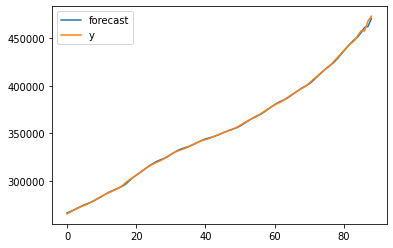

In [ ]:
fig = model_fit.plot_predict()

ARIMA 모델을 이용한 시계열 예측모델은 코로나 확진자수 예측과 거의 유사하다고 볼 수 있습니다.   
참고) https://dacon.io/codeshare/2570 

## 2. Prophet 모델을 이용하여 예측하기

In [ ]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

import numpy as np

+ 데이터 가공하기

In [ ]:
korea = data[data['Country/Region'] == 'Korea, South']

korea = np.column_stack([korea.Date, korea.Confirmed]) #두 배열 붙이기
korea =  pd.DataFrame(korea)

korea = korea.reset_index().rename(columns={0: 'date', 1: 'confirmed'})
korea = korea.drop("index", axis=1)

+ 확진자 그래프그리기

In [19]:
fig = go.Figure()
fig.add_trace(
    go.Scatter( x=korea.date, y=korea.confirmed,)
)
fig

+ 예측모델 만들기(14일 예측)

Prophet 모델을 이용하여 예측합니다.   
유연성이 0.3과 0.2의 차이가 크지 않아 0.3으로 정하였습니다.   
년도별 주기를 반영하기에는 2년의 데이터 크기를 가지고 있기 때문에, yearly_seasonality를 false로 두었습니다.   
각 데이터별로 덧셈을 반영하였습니다.   

In [20]:
model = Prophet(
    changepoint_prior_scale = 0.3, 
    yearly_seasonality=False, 
    weekly_seasonality=True, 
    daily_seasonality=True,
    seasonality_mode='additive'
)

prophet = korea.rename(columns={'date': 'ds', 'confirmed': 'y'})

model.fit(prophet)

confirm_pre = model.make_future_dataframe(periods = 14) #14일 예측  
forecast = model.predict(confirm_pre)

fig = plot_plotly(model, forecast)
py.iplot(fig)

빨간 실선은 트렌드, 변화하는 changepoint를 표시합니다.


Text(41.375, 0.5, 'confirmed')

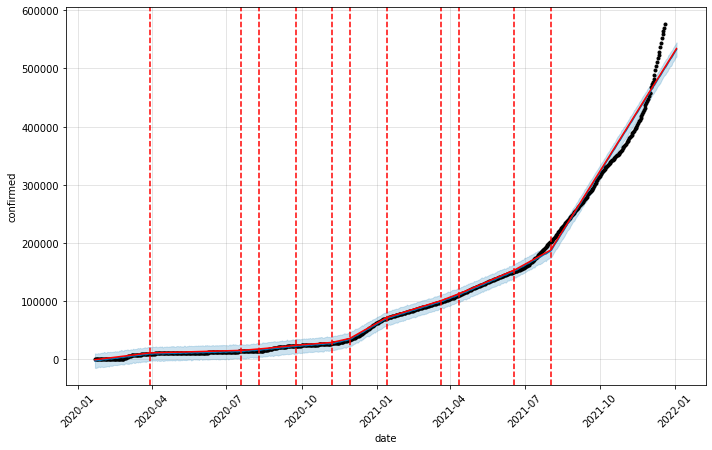

In [21]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ylabel('confirmed')

참고) https://github.com/kairess/corona-virus-prediction/blob/master/corona19_confirmed_prediction.ipynb 